# 順序尺度の相関係数

アンケート調査の「1: あてはまらない」「2: どちらともいえない」「3: あてはまる」のような3値をとる順序尺度の変数や、「該当する」「該当しない」のような二値変数のような、値の種類数が比較的少ない順序尺度の相関係数は、ピアソンの積率相関係数で測った場合過小評価される（絶対値が小さくなる傾向がある）。これは**相関係数の希薄化**と呼ばれる現象である。


:::{hint}
「5値以上あれば積率相関係数でも誤差があまり大きくないため、連続尺度の変数のように積率相関係数にもとづいて相関を分析してもよい」という研究結果もある。

「1: 全くあてはまらない」「2: あまりあてはまらない」...「5: よくあてはまる」の5件法がよく使われる理由のひとつはこのため。

（[萩生田 & 繁桝 1996](https://www.jstage.jst.go.jp/article/jjpsy1926/67/1/67_1_1/_article/-char/ja/)）
:::


こうした問題に対処するために、次のような相関係数が存在する。

- **ポリコリック相関係数**（polychoric correlation）：順序尺度同士の相関係数
- **ポリシリアル相関係数**（polyserial correlation）：順序尺度と連続尺度の相関係数

## 例

以下のようなデータがあるとする

In [317]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
from scipy.stats import multivariate_normal, pearsonr
from semopy.model import hetcor


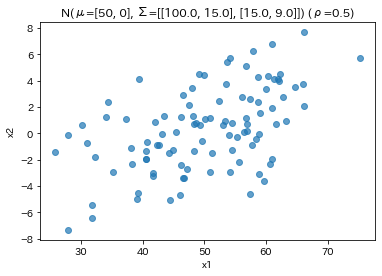

In [318]:
# generate data
n = 100
mean = [50, 0]
std = [10, 3]
rho = 0.5
cov = rho * std[0] * std[1]
Cov = np.array([
    [std[0]**2, cov],
    [cov, std[1]**2]
])

X = multivariate_normal.rvs(mean=mean, cov=Cov, size=n, random_state=0)

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], alpha=.7)
ax.set(xlabel="x1", ylabel="x2", title=f"N(μ={mean}, Σ={Cov.tolist()}) (ρ={rho})")
fig.show()

適当な閾値で区切って離散化したとする。

In [319]:
# 離散化
d1 = X[:, 0] >= X[:, 0].mean()
d2 = np.ones(shape=(n, ))
d2[(-4 <= X[:, 1]) & (X[:, 1] < 4)] = 2
d2[(4 <= X[:, 1])] = 3

D = np.array([d1, d2]).T
D = pd.DataFrame(D, columns=["d1", "d2"]).astype(int)

table = pd.crosstab(D["d1"], D["d2"])
print("離散化したデータのクロス集計表")
table #.style.set_caption("クロス集計表")

離散化したデータのクロス集計表


d2,1,2,3
d1,,,
0,7,39,2
1,1,38,13


離散化前の量的変数に積率相関係数を適用した場合と、離散化後の質的変数に積率相関係数を使用した場合、そしてポリコリック相関係数を使用した場合の結果は次のようになる。

質的変数にピアソンの積率相関係数を使用すると、相関が過小評価されていること、そしてポリコリック相関係数のほうが離散化前の相関係数の再現度がより高いことがわかる。

In [320]:
from semopy.polycorr import polychoric_corr

pd.DataFrame([
    dict(method="積率相関係数を量的変数に適用", value=pearsonr(X[:, 0], X[:, 1]).statistic),
    dict(method="積率相関係数を質的変数に適用", value=D.corr().iloc[0, 1]),
    dict(method="ポリコリック相関係数を質的変数に適用", value=polychoric_corr(D["d1"], D["d2"]))
]).style.format({"value": "{:.3f}"})

,method,value
0,積率相関係数を量的変数に適用,0.517
1,積率相関係数を質的変数に適用,0.353
2,ポリコリック相関係数を質的変数に適用,0.570


## 順序尺度の相関係数はどういうふうに推定するのか

基本的な考え方としては、「離散値の背景には何らかの連続尺度が潜在的に存在する」という仮定をおくものである。

例えばアンケート調査なら、その潜在的な連続変数が一定のしきい値以上になった場合に「よくあてはまる」といった回答がなされている、と考える。

より具体的には次の節で述べる。


## ポリコリック相関係数の推定方法

[小杉考司（2013）](http://kosugitti.sakura.ne.jp/wp/wp-content/uploads/2013/08/polynote.pdf)を参考に、二段階の最尤推定を行う方法を紹介する。
この方法はシンプルでわかりやすく、またsemopyなどのライブラリでも利用されている。


まず、観測された順序尺度の変数の背景に連続尺度の変数が存在し、それらは二変量の標準正規分布に従うと仮定する。


2変量正規分布の空間を閾値で区切って離散化されたものが観測値として実現したと考える。

### 尤度関数

クロス集計表におけるセル$(i, j)$の観測度数を$n_{ij}$とする（$i=1,2,\cdots, s, \ j=1,2,\cdots,r$）。

観測度数がセル$(i, j)$に含まれる確率を$\pi_{ij}$とすれば、そのサンプルの尤度は

$$
L = C \prod^s_{i=1} \prod^r_{j=1} \pi_{ij}^{n_{ij}}
$$

である。ここで$C$は定数で、最尤推定においては推定に関わらないので気にしなくてよい。対数尤度は

$$
\ell = \ln L = \ln C + \sum^s_{i=1} \sum^r_{j=1} n_{ij} \ln \pi_{ij}
$$


相関を測りたい変数が$x,y$の2つあるとし、変数$x$の閾値を$a_i$、変数$y$の閾値を$b_j$と表す（$i=0, 1,2,\cdots, s, \ j=0,1,2,\cdots,r$）。
ここで$a_0 = b_0 = -\infty, a_s = b_r = +\infty$である。

$\pi_{ij}$は相関係数$\rho$のおｔきの2変数正規分布$\Phi_2$を用いて

$$
\pi_{ij} = \Phi_2(a_i, b_j)
- \Phi_2(a_{i-1}, b_j)
- \Phi_2(a_i, b_{j-1})
+ \Phi_2(a_{i-1}, b_{j-1})
$$

と表すことができる。

### 推定

閾値は次のように推定することができる。

$$
a_i = \Phi_1^{-1}(P_{i \cdot})\\
b_j = \Phi_1^{-1}(P_{\cdot j})
$$

ここで$P_{i \cdot}, P_{\cdot j}$は観測された累積周辺分布である。


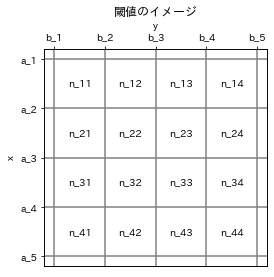

In [321]:
fig, ax1 = plt.subplots(figsize=[4, 4])

k = 5
ticks = range(0, 2 * k, 2)
ticklabels_a = [f"a_{i}" for i in range(1, k + 1)]
ticklabels_b = [f"b_{i}" for i in range(1, k + 1)]

for tick in ticks:
    ax1.axhline(tick, color="gray")
    ax1.axvline(tick, color="gray")

cell_coords = range(1, 2 * k - 1, 2)
for i_show, i in enumerate(cell_coords, start=1):
    for j_show, j in enumerate(cell_coords, start=1):
        ax1.text(j, i, f"n_{i_show}{j_show}", ha="center", va="center")

ax1.set(ylabel="x", xticks=[], title="閾値のイメージ")
ax1.set_yticks(ticks=ticks, labels=ticklabels_a)
ax1.invert_yaxis()

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("y")
ax2.set_xticks(ticks=ticks, labels=ticklabels_b)
fig.show()

### 推定の流れ

実際に推定してみよう。

まずクロス集計表を作って観測度数を得る。

In [322]:
table = pd.crosstab(D["d1"], D["d2"])
table

d2,1,2,3
d1,,,
0,7,39,2
1,1,38,13


クロス集計表を横軸や縦軸に向けて合計していき、累積周辺分布$P_{i \cdot}, P_{\cdot j}$を得る


In [323]:
# 累積周辺分布
n = table.sum().sum()
P1 = table.sum(axis=1).cumsum().to_list() / n
P2 = table.sum(axis=0).cumsum().to_list() / n
P2

array([0.08, 0.85, 1.  ])

$a_i, b_j$を推定する。$a_0 = b_0 = -\infty$、$a_s = b_r = \infty$となるようにする

In [324]:
# 閾値a, bを推定
from scipy.stats import norm
a = norm.ppf(P1, loc=0, scale=1)
b = norm.ppf(P2, loc=0, scale=1)

a = [-np.inf, *a]
b = [-np.inf, *b]
b

[-inf, -1.4050715603096329, 1.0364333894937898, inf]

確率密度

$$
\pi_{ij} = \Phi_2(a_i, b_j)
- \Phi_2(a_{i-1}, b_j)
- \Phi_2(a_i, b_{j-1})
+ \Phi_2(a_{i-1}, b_{j-1})
$$

の推定と、対数尤度

$$
\ln L = \ln C + \sum^s_{i=1} \sum^r_{j=1} n_{ij} \ln \pi_{ij}
$$

の計算を行う関数を作る

In [400]:
from scipy.stats import multivariate_normal

def log_likelihood(rho, a=a, b=b, table=table):
    Cov = np.array([
        [1, rho],
        [rho, 1]
    ])
    n = np.array(table)
    likelihood = 0
    for i in range(1, len(a)):
        for j in range(1, len(b)):
            ij = multivariate_normal.cdf([a[i], b[j]], mean=[0, 0], cov=Cov)
            ij = 0 if np.isnan(ij) else ij

            i1j = multivariate_normal.cdf([a[i-1], b[j]], mean=[0, 0], cov=Cov)
            i1j = 0 if np.isnan(i1j) else i1j

            ij1 = multivariate_normal.cdf([a[i], b[j-1]], mean=[0, 0], cov=Cov)
            ij1 = 0 if np.isnan(ij1) else ij1

            i1j1 = multivariate_normal.cdf([a[i-1], b[j-1]], mean=[0, 0], cov=Cov)
            i1j1 = 0 if np.isnan(i1j1) else i1j1
            pi = ij - i1j - ij1 + i1j1
            # ちなみにpiの推定は上記のように愚直にやらずとも scipy.stats の mvn.mvnun でもできる

            if pi > 0:
                likelihood += n[i-1, j-1] * np.log(pi)
    return likelihood

log_likelihood(rho=0.1)

-135.95432934194218

尤度を最大にする$\rho$を探索する。

今回は$\rho$が$(-1, 1)$にあることがわかっているので、その範囲を細かく刻んで全部計算して最良の$\rho$を推定値とする、という全探索法をつかうこともできる。

この方法を実際に行ったのが次の図である。

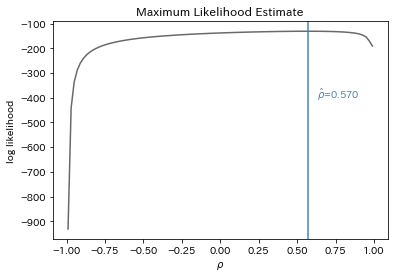

In [402]:
# 最尤推定1: 全探索
rho_range = np.linspace(-0.99, 0.99, 100)
likelihoods = np.array([log_likelihood(rho) for rho in rho_range])
rho_hat = rho_range[np.argmax(likelihoods)]

fig, ax = plt.subplots()
ax.plot(rho_range, likelihoods, color="dimgray")
ax.set(xlabel=r"$\rho$", ylabel="log likelihood", title="Maximum Likelihood Estimate")

l = likelihoods[~np.isinf(likelihoods)]
y = -(l.max() - l.min()) / 2
ax.text(rho_hat * 1.1, y, r"$\hat{\rho}$"+f"={rho_hat:.3f}", color="steelblue")
ax.axvline(rho_hat, color="steelblue")

fig.show()

`scipy.optimize.fminbound`などを使ってBrent法という最適化手法を用いると効率的である。

（実際、`semopy`や`RyStats`などのパッケージではscipyの最適化関数を呼び出すことでBrent法を使っている: [semopy/polycorr.py](https://gitlab.com/georgy.m/semopy/-/blob/master/semopy/polycorr.py)）

In [364]:
# ※minimizeの関数に入れるために負の対数尤度にしている
from scipy.optimize import fminbound
fminbound(lambda rho: -log_likelihood(rho), -0.999, 0.999)

0.5697450392309811

## カテゴリの値がいくつだと積率相関係数でもよいか

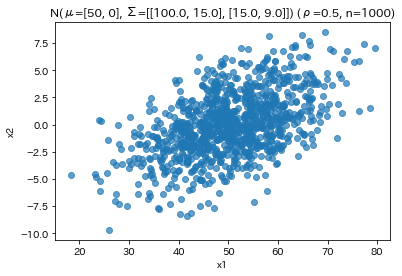

In [425]:
# generate data
n = 1000
mean = [50, 0]
std = [10, 3]
rho = 0.5
cov = rho * std[0] * std[1]
Cov = np.array([
    [std[0]**2, cov],
    [cov, std[1]**2]
])

X = multivariate_normal.rvs(mean=mean, cov=Cov, size=n, random_state=0)
X = pd.DataFrame(X)

fig, ax = plt.subplots()
ax.scatter(X[0], X[1], alpha=.7)
ax.set(xlabel="x1", ylabel="x2", title=f"N(μ={mean}, Σ={Cov.tolist()}) (ρ={rho}, n={n})")
fig.show()

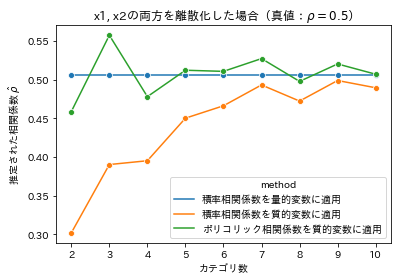

In [426]:
results = []
for k in range(2, 11):
    d1 = pd.cut(X[0], bins=k, labels=range(k)).astype(int)
    d2 = pd.cut(X[1], bins=k, labels=range(k)).astype(int)

    result = [
        dict(method="積率相関係数を量的変数に適用", value=pearsonr(X[0], X[1]).statistic, k=k),
        dict(method="積率相関係数を質的変数に適用", value=pearsonr(d1, d2).statistic, k=k),
        dict(method="ポリコリック相関係数を質的変数に適用", value=polychoric_corr(d1, d2), k=k)
    ]
    results += result
results = pd.DataFrame(results)

import seaborn as sns
sns.lineplot(x="k", y="value", data=results, hue="method", marker="o")
plt.xlabel("カテゴリ数")
plt.ylabel(r"推定された相関係数 $\hat{\rho}$")
plt.title(r"x1, x2の両方を離散化した場合（真値：$\rho = 0.5$）")
plt.show()

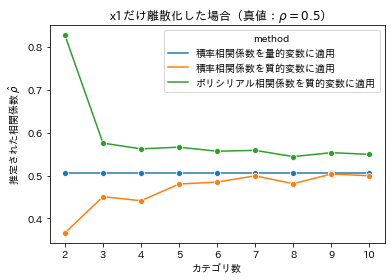

In [429]:
from semopy.polycorr import polyserial_corr

results = []
for k in range(2, 11):
    d1 = pd.cut(X[0], bins=k, labels=range(k)).astype(int)

    result = [
        dict(method="積率相関係数を量的変数に適用", value=pearsonr(X[0], X[1]).statistic, k=k),
        dict(method="積率相関係数を質的変数に適用", value=pearsonr(d1, X[1]).statistic, k=k),
        dict(method="ポリシリアル相関係数を質的変数に適用", value=polyserial_corr(X[1], d1), k=k)
    ]
    results += result
results = pd.DataFrame(results)

import seaborn as sns
sns.lineplot(x="k", y="value", data=results, hue="method", marker="o")
plt.xlabel("カテゴリ数")
plt.ylabel(r"推定された相関係数 $\hat{\rho}$")
plt.title(r"x1だけ離散化した場合（真値：$\rho = 0.5$）")
plt.show()

## 参考文献

- 豊田秀樹（2012）『因子分析入門』、東京図書。
- [小杉考司（2013）順序尺度の相関係数（ポリコリック相関係数）について](http://kosugitti.sakura.ne.jp/wp/wp-content/uploads/2013/08/polynote.pdf)
- [萩生田伸子, & 繁桝算男. (1996). 順序付きカテゴリカルデータへの因子分析の適用に関するいくつかの注意点. 心理学研究, 67(1), 1-8.](https://www.jstage.jst.go.jp/article/jjpsy1926/67/1/67_1_1/_article/-char/ja/)
